# (MBTI) Myers-Briggs Personality Type Prediction

* Extroversion vs. Introversion
    * I - 0
    * E - 1 
    
* Sensing vs. Intuition 
    * N - 0 
    * S - 1
    
* Thinking vs. Feeling
    * F - 0
    * T - 1
    
* Judging vs. Perceiving
    * P - 0
    * J - 1 
    
## MACHINE LEARNING - IMPLEMENTING & COMPARING DIFFERENT CLASSIFIERS  

In [23]:
# importing dependencies here
import numpy as np
import pandas as pd
import os

# visualizations
import matplotlib.pyplot as plt

# data stratifying and splitting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# algorithms/models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# saving the model
from joblib import dump

In [24]:
# reading the final dataset
path_to_csv = os.path.join("..", "data", "clean_data_3.csv")
personality_data = pd.read_csv(path_to_csv)

In [25]:
# checking top records
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,compound_sentiment,pos_sentiment,neg_sentiment,...,em,colons,emojis,word_count,unique_words,post_length_var,upper,link_count,ellipses,img_count
0,INFJ,0,0,0,1,'When asked of the things you wish you did ear...,asked thing wish earlier find answering...,0.99980,0.418667,0.136150,...,0.22,0.32,0.08,30.98,14.92,78.414931,1.46,0.04,0.62,0.0
1,INFJ,0,0,0,1,'I love both and they are equally important to...,love equally important music window soul in...,0.99995,0.600000,0.134585,...,0.36,0.14,0.00,28.58,12.72,160.744400,1.62,0.02,0.04,0.0


### Setting predictors and target variable


In [26]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = personality_data[
    [
        "clean_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "qm",
        "em",
        "colons",
        "emojis",
        "word_count",
        "unique_words",
        "upper",
        "link_count",
        "ellipses",
        "img_count",
    ]
]

# setting y to four target classes -> is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = personality_data.iloc[:, 1:5]

# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(8588, 22)
(8588, 4)


### Creating a list of words (other than the stop words) to be dropped to improve model performanace

In [27]:
additional_stopwords = [
    "hey",
    "hello",
    "briggs",
    "cat",
    "car",
    "mbti",
    "soup",
    "tea",
    "sport",
    "snow",
    "christmas",
]

### Setting up preprocessor for vectorization and selecting best counts and scores

In [28]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_n_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colons",
    "emojis",
    "word_count",
    "unique_words",
    "upper",
    "link_count",
    "ellipses",
    "img_count",
]

# for selecting k best features from features other than words
best_k_features = make_pipeline(MinMaxScaler(), SelectKBest(f_classif, k=10))

# setting up preprocessing for TF-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

# setting up preprocessing for COUNT vectorizer
preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "ct_vect",
            CountVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

### Modelling

In [29]:
# setting up the personality dictionary for printing scores for each class
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}

# function to build the model for predicting each of the 4 target classes
def build_model(model, X, target, vectorizer_name):

    for col in target.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )

        # model training
        model.fit(X_train, y_train)

        # y_hat
        y_pred = model.predict(X_test)

        # y_probability
        y_proba = model.predict_proba(X_test)[:, 1]

        # precision recall score
        average_precision = average_precision_score(y_test, y_proba)

        # model evaluation
        print(
            f"Geometric Mean Score: {geometric_mean_score(y_test, y_pred, average='weighted'):.2f}"
        )
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
        print(f"Average Precision-Recall Score: {average_precision:.2f}")
        print(classification_report_imbalanced(y_test, y_pred))


### TF-IDF Logistic Regression

In [9]:
%%time

tfidf_logistic_regression = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(tfidf_logistic_regression, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.68
ROC-AUC Score: 0.76
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.67      0.68      0.76      0.68      0.46      1322
          1       0.38      0.68      0.67      0.49      0.68      0.46       396

avg / total       0.76      0.67      0.68      0.70      0.68      0.46      1718


Sensing vs Intuition
Geometric Mean Score: 0.73
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.70      0.77      0.80      0.73      0.53      1481
          1       0.29      0.77      0.70      0.42      0.73      0.54       237

avg / total       0.86      0.71      0.76      0.75      0.73      0.53      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

### Count Vectorized Logistic Regression

In [10]:
%%time
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(ct_logistic_regression, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.66      0.61      0.75      0.64      0.41      1322
          1       0.35      0.61      0.66      0.45      0.64      0.41       396

avg / total       0.74      0.65      0.63      0.68      0.64      0.41      1718


Sensing vs Intuition
Geometric Mean Score: 0.69
ROC-AUC Score: 0.76
Average Precision-Recall Score: 0.32
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.65      0.73      0.77      0.69      0.47      1481
          1       0.25      0.73      0.65      0.37      0.69      0.48       237

avg / total       0.84      0.66      0.72      0.71      0.69      0.47      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.82
           

### TF-IDF Logistic Lasso

In [11]:
%%time
tfidf_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(tfidf_logistic_regression_lasso, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.66
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.43
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.65      0.66      0.74      0.66      0.43      1322
          1       0.36      0.66      0.65      0.47      0.66      0.43       396

avg / total       0.75      0.66      0.66      0.68      0.66      0.43      1718


Sensing vs Intuition
Geometric Mean Score: 0.69
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.32
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.64      0.74      0.76      0.69      0.47      1481
          1       0.25      0.74      0.64      0.37      0.69      0.48       237

avg / total       0.84      0.65      0.72      0.71      0.69      0.47      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.82
           

### Count Vectorized Logistic Lasso

In [12]:
%%time
ct_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(ct_logistic_regression_lasso, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.62
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.36
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.66      0.59      0.74      0.62      0.39      1322
          1       0.34      0.59      0.66      0.43      0.62      0.38       396

avg / total       0.73      0.64      0.61      0.67      0.62      0.39      1718


Sensing vs Intuition
Geometric Mean Score: 0.64
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.29
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.65      0.63      0.76      0.64      0.41      1481
          1       0.22      0.63      0.65      0.33      0.64      0.41       237

avg / total       0.82      0.64      0.63      0.70      0.64      0.41      1718


Thinking vs Feeling
Geometric Mean Score: 0.75
ROC-AUC Score: 0.83
Average Precision-Recall Score: 0.79
           

### TF-IDF Logistic Ridge

In [13]:
%%time
tfidf_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(tfidf_logistic_regression_ridge, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.68
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.68      0.69      0.76      0.68      0.47      1322
          1       0.39      0.69      0.68      0.50      0.68      0.47       396

avg / total       0.77      0.68      0.69      0.70      0.68      0.47      1718


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.41
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.70      0.71      0.80      0.71      0.50      1481
          1       0.27      0.71      0.70      0.40      0.71      0.50       237

avg / total       0.85      0.70      0.71      0.74      0.71      0.50      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

### Count Vectorized Logistic Ridge

In [14]:
%%time
ct_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(ct_logistic_regression_ridge, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.67      0.61      0.75      0.64      0.41      1322
          1       0.36      0.61      0.67      0.45      0.64      0.41       396

avg / total       0.74      0.66      0.62      0.68      0.64      0.41      1718


Sensing vs Intuition
Geometric Mean Score: 0.69
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.67      0.70      0.78      0.69      0.47      1481
          1       0.25      0.70      0.67      0.37      0.69      0.47       237

avg / total       0.84      0.67      0.70      0.72      0.69      0.47      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.82
           

### TF-IDF Logistic Elasticnet

* Takes longest to run and the results are almost same as lasso and ridge model. So this code is commented to save time when re-running the entire notebook.

In [15]:
# %%time

# for col in y.columns:

#     print(f"\n{mbti_type[col]}")

#     target = y[col]

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, target, test_size=0.2, random_state=42, stratify=target
#     )

#     tfidf_logistic_regression_elasticnet = imb_make_pipeline(
#         preprocesser_tf,
#     #     DenseTransformer(),
#         RandomUnderSampler(),
#         LogisticRegressionCV(
#             penalty='elasticnet',
#             l1_ratios=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
#             solver='saga'
#         )
#     )

#     tfidf_logistic_regression_elasticnet.fit(X_train, y_train)

#     print(f'Accuracy: {tfidf_logistic_regression_elasticnet.score(X_test, y_test)} \n')
#     print(classification_report(y_test, tfidf_logistic_regression_elasticnet.predict(X_test)))

### TF-IDF Support Vector Classifier

In [16]:
%%time
tfidf_svc = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), DenseTransformer(), SVC(kernel='linear',probability=True)
)
build_model(tfidf_svc, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.68
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.45
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.67      0.68      0.76      0.68      0.46      1322
          1       0.39      0.68      0.67      0.49      0.68      0.46       396

avg / total       0.76      0.68      0.68      0.70      0.68      0.46      1718


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.41
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.68      0.74      0.79      0.71      0.50      1481
          1       0.27      0.74      0.68      0.39      0.71      0.51       237

avg / total       0.85      0.69      0.73      0.73      0.71      0.50      1718


Thinking vs Feeling
Geometric Mean Score: 0.78
ROC-AUC Score: 0.86
Average Precision-Recall Score: 0.83
           

### Count Vectorized Support Vector Classifier

In [17]:
%%time
ct_svc = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), SVC(kernel='linear',probability=True)
)
build_model(ct_svc, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.61
ROC-AUC Score: 0.66
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.61      0.61      0.70      0.61      0.37      1322
          1       0.32      0.61      0.61      0.42      0.61      0.37       396

avg / total       0.72      0.61      0.61      0.64      0.61      0.37      1718


Sensing vs Intuition
Geometric Mean Score: 0.66
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.27
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.62      0.70      0.74      0.66      0.43      1481
          1       0.23      0.70      0.62      0.34      0.66      0.44       237

avg / total       0.83      0.63      0.69      0.69      0.66      0.43      1718


Thinking vs Feeling
Geometric Mean Score: 0.72
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.75
           

### TF-IDF Naive Bayes

In [18]:
%%time
tfidf_nb = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(tfidf_nb, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.68
ROC-AUC Score: 0.76
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.61      0.76      0.73      0.68      0.45      1322
          1       0.37      0.76      0.61      0.49      0.68      0.47       396

avg / total       0.77      0.64      0.72      0.67      0.68      0.46      1718


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.63      0.78      0.76      0.71      0.49      1481
          1       0.26      0.78      0.63      0.39      0.71      0.51       237

avg / total       0.85      0.66      0.76      0.71      0.71      0.49      1718


Thinking vs Feeling
Geometric Mean Score: 0.76
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.80
           

### Count Vectorized Naive Bayes

In [19]:
%%time
ct_nb = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(ct_nb, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.69
ROC-AUC Score: 0.76
Average Precision-Recall Score: 0.44
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.67      0.71      0.76      0.69      0.48      1322
          1       0.39      0.71      0.67      0.51      0.69      0.48       396

avg / total       0.77      0.68      0.70      0.71      0.69      0.48      1718


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.67      0.75      0.78      0.71      0.50      1481
          1       0.27      0.75      0.67      0.39      0.71      0.51       237

avg / total       0.85      0.68      0.74      0.73      0.71      0.50      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.79
           

### TF-IDF Random Forest

In [20]:
%%time
tfidf_rf = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(),
        RandomUnderSampler(),
        RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(tfidf_rf, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.63
ROC-AUC Score: 0.68
Average Precision-Recall Score: 0.38
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.62      0.65      0.72      0.63      0.40      1322
          1       0.34      0.65      0.62      0.45      0.63      0.40       396

avg / total       0.74      0.63      0.64      0.66      0.63      0.40      1718


Sensing vs Intuition
Geometric Mean Score: 0.63
ROC-AUC Score: 0.68
Average Precision-Recall Score: 0.24
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.60      0.67      0.72      0.63      0.40      1481
          1       0.21      0.67      0.60      0.32      0.63      0.40       237

avg / total       0.82      0.61      0.66      0.67      0.63      0.40      1718


Thinking vs Feeling
Geometric Mean Score: 0.72
ROC-AUC Score: 0.81
Average Precision-Recall Score: 0.77
           

### Count Vectorized Random Forest

In [21]:
%%time
ct_rf = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(ct_rf, X, y, "ct_vect")


Extrovert vs Introvert
Geometric Mean Score: 0.67
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.41
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.65      0.68      0.75      0.67      0.44      1322
          1       0.37      0.68      0.65      0.48      0.67      0.44       396

avg / total       0.76      0.66      0.67      0.68      0.67      0.44      1718


Sensing vs Intuition
Geometric Mean Score: 0.63
ROC-AUC Score: 0.69
Average Precision-Recall Score: 0.26
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.62      0.63      0.74      0.63      0.39      1481
          1       0.21      0.63      0.62      0.32      0.63      0.39       237

avg / total       0.82      0.62      0.63      0.68      0.63      0.39      1718


Thinking vs Feeling
Geometric Mean Score: 0.75
ROC-AUC Score: 0.81
Average Precision-Recall Score: 0.76
           

### Final Model - Logistic Regression with TF-IDF Vectorization

Selecting TF-IDF Logistic Regression as our final model as it returned the highest scores for all metrics - accuracy, precision, recall, roc-auc, avg_precision_recall as compared to other models.


Extrovert vs Introvert
               coef
word               
fun        3.622478
family    -3.557056
guy        2.914919
bored      2.775526
quiet     -2.650959
crazy      2.619775
feel      -2.618277
term       2.592708
dream     -2.497217
business   2.486883
love       2.448212
developed  2.431994
awesome    2.398077
mother    -2.371457
challenge  2.370254
let        2.224689
debate     2.220901
game      -2.198330
mind      -2.162094
super      2.152042
death     -2.135652

Sensing vs Intuition
                coef
word                
rant        6.318052
perc        6.264254
sensing     5.758763
dark       -5.755844
type        5.485660
romantic   -5.320687
dominant    4.921541
world      -4.854404
attachment -4.835884
practical   4.820510
inferior    4.734634
ill         4.604881
sometimes  -4.494521
concrete    4.300206
idea       -4.297607
luck       -4.290984
recognize  -4.075143
soul       -4.073386
crush      -4.031138
music       3.999383
hope       -3.986743

Thinking v

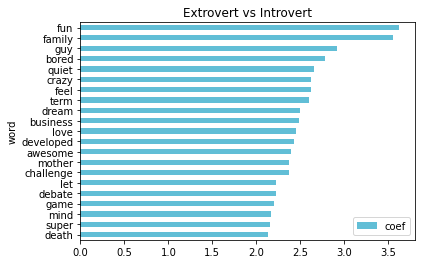

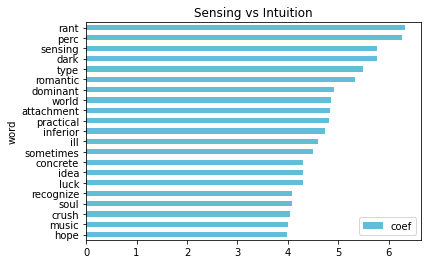

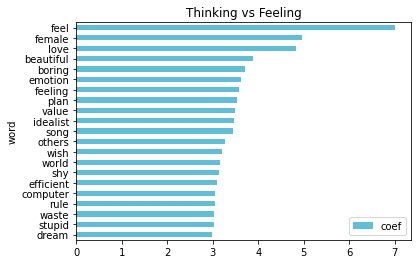

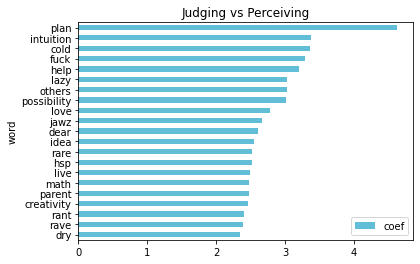

In [30]:
%%time

for col in y.columns:
    
    print(f"\n{mbti_type[col]}")

    target = y[col]

    tfidf_logistic_regression = imb_make_pipeline(
        preprocesser_tf,
        RandomUnderSampler(),
        LogisticRegressionCV()
    )
    
    # training the data on entire dataset
    tfidf_logistic_regression.fit(X, target)
    
    # feature importance   
    coef = tfidf_logistic_regression[-1].coef_[0]  
    word = tfidf_logistic_regression[0].named_transformers_["tfidf"].get_feature_names()
    word_list = list(zip(word, coef))         
    result = pd.DataFrame(word_list, columns=["word", "coef"]).set_index("word")    
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting feature importance
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])
  
    # saving the model
    dump(tfidf_logistic_regression, f"clf_{col}.joblib")